In [105]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
import sys
sys.path.append('../')

import pandas
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils.eye_tracking_data import get_eye_tracking_data, with_time_since_start_column
from src.config import RAW_EYE_TRACKING_FRAME_WIDTH, RAW_EYE_TRACKING_FRAME_HEIGHT

N_NANOSECONDS_IN_SECOND = 1e9  # Number of nanoseconds in a second

OUTPUT_FILE_PATH = "../data/result.mp4"

## Loading Processed Data

In [107]:
data = get_eye_tracking_data()
data = with_time_since_start_column(data)
data.head()

,ExperimentId,SessionId,ParticipantId,SequenceId,GazeX_sc,GazeY_sc,GazeX_px,GazeY_px,Timestamp_ns,TimeSinceStart_ns
0,1,1,1,1,0.813762,0.661315,4999.7515,2031.5590,8492802345543344252,0.0
1,1,1,1,1,0.739250,0.870603,4541.9500,2674.4930,8492802345801721952,258377700.0
2,1,1,1,1,0.680598,0.649704,4181.5950,1995.8899,8492802345847617152,304272900.0
3,1,1,1,1,0.663174,0.657053,4074.5400,2018.4670,8492802345951811152,408466900.0
4,1,1,1,1,0.548628,0.777003,3370.7708,2386.9520,8492802346058247252,514903000.0


In [108]:
interpolated_data = get_eye_tracking_data(interpolated=True)
interpolated_data = with_time_since_start_column(interpolated_data)
interpolated_data.head()

,ExperimentId,SessionId,ParticipantId,SequenceId,GazeX_sc,GazeY_sc,GazeX_px,GazeY_px,Timestamp_ns,TimeSinceStart_ns
0,1,1,1,1,0.813762,0.661315,4999.7515,2031.5590,8492802345500000000,0.0
1,1,1,1,1,0.779149,0.694261,4787.0920,2132.7698,8492802345600000000,100000000.0
2,1,1,1,1,0.744536,0.727207,4574.4320,2233.9805,8492802345700000000,200000000.0
3,1,1,1,1,0.709924,0.760154,4361.7725,2335.1914,8492802345800000000,300000000.0
4,1,1,1,1,0.663174,0.657053,4074.5400,2018.4670,8492802345900000000,400000000.0


## Number of Data Points Over Time

In [109]:
def plot_number_data_points_over_time(
    data: pd.DataFrame,
) -> None:
    """
    Plot the data points over time.

    Args:
        data (pandas.DataFrame): The data to plot.
    """
    # Convert the time to seconds
    data = data.copy()
    data["TimeSinceStart_s"] = data["TimeSinceStart_ns"] / N_NANOSECONDS_IN_SECOND
    data = data["TimeSinceStart_s"].astype(int).value_counts().sort_index().reset_index()

    # Plot the histogram
    plt.bar(data["TimeSinceStart_s"], data["count"], width=1.0)
    plt.xlabel("Time (s)")
    plt.ylabel("Number of data points")
    plt.yscale("log")
    plt.title("Number of data points over time (log scale)")
    plt.show()

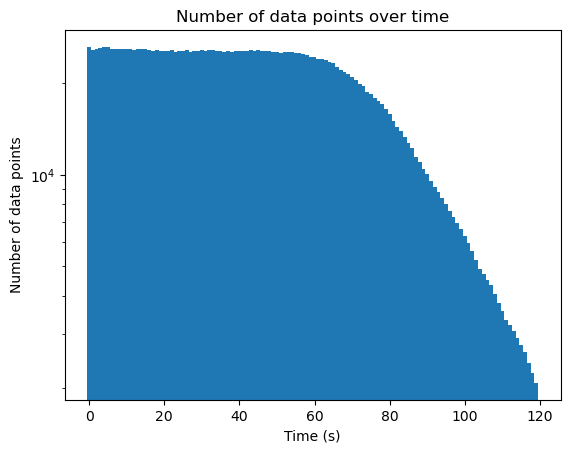

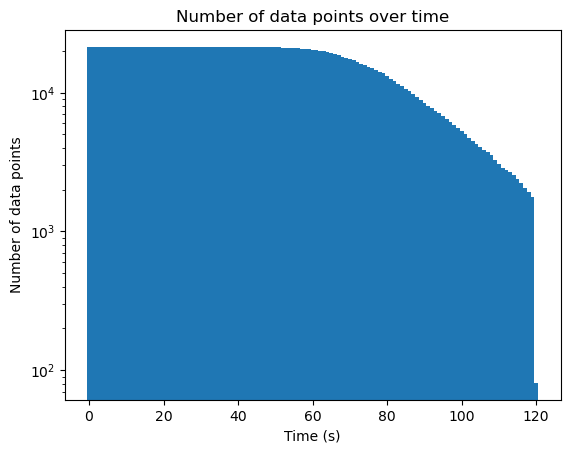

In [110]:
plot_number_data_points_over_time(data)
plot_number_data_points_over_time(interpolated_data)

## Distribution of Data Points Frequency

In [120]:
def with_time_since_last_column(
    data: pd.DataFrame,
) -> pd.DataFrame:
    """
    Add a column with the time since the previous gaze point in seconds.

    Args:
        data (pd.DataFrame): The eye tracking data.

    Returns:
        pd.DataFrame: The eye tracking data with the time since last gaze point column.
    """
    data = data.groupby(["ExperimentId", "SessionId", "ParticipantId", "SequenceId"])
    groups = [data.get_group(group) for group in data.groups]

    for i, group in enumerate(groups):
        group = group.copy()
        group = group.sort_values("Timestamp_ns")
        time_since_last = group["Timestamp_ns"].diff().fillna(0)
        group["TimeSinceLast_ns"] = time_since_last
        groups[i] = group
    data = pandas.concat(groups)

    return data

def plot_data_points_frequency(
    data: pd.DataFrame,
) -> None:
    data = data.copy()
    data = with_time_since_last_column(data)
    data['Experiment_Session'] = data.apply(
        lambda row: f"Experiment {int(row['ExperimentId'])} Session {int(row['SessionId'])}", axis=1
    )

    # Remove outliers based on quantiles
    q_low = data["TimeSinceLast_ns"].quantile(0.025)
    q_hi = data["TimeSinceLast_ns"].quantile(0.975)
    data = data[(data["TimeSinceLast_ns"] < q_hi) & (data["TimeSinceLast_ns"] > q_low)]

    # Plot histogram
    sns.histplot(
        data=data,
        x='TimeSinceLast_ns',
        hue='Experiment_Session',
        bins=50,
        log_scale=True,
    )
    plt.xlabel("Time since last gaze point (ns)")
    plt.ylabel("Number of data points")
    plt.title("Time since last gaze point (outliers removed)")
    plt.show()

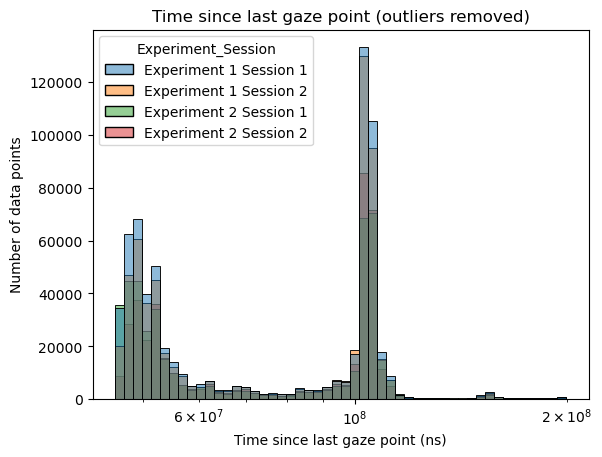

In [121]:
plot_data_points_frequency(data)

## Mean Travelled Distance Over Time 

In [36]:
def with_distance_since_last_column(
    data: pd.DataFrame,
) -> pd.DataFrame:
    """
    Add a column with the distance between the current and the previous gaze point in pixels.

    Args:
        data (pd.DataFrame): The eye tracking data.

    Returns:
        pd.DataFrame: The eye tracking data with the distance since last gaze point column.
    """
    # Group the data by experiment, session, participant, and sequence
    data = data.copy()
    data = data.groupby(["ExperimentId", "SessionId", "ParticipantId", "SequenceId"])
    groups = [data.get_group(group) for group in data.groups]

    # Calculate the distance since the last gaze point for each group
    for i, group in enumerate(groups):
        group = group.copy()
        group = group.sort_values("Timestamp_ns")
        gaze_x_diff = group["GazeX_px"].diff().fillna(0)
        gaze_y_diff = group["GazeY_px"].diff().fillna(0)
        distance_since_last = np.sqrt(gaze_x_diff**2 + gaze_y_diff**2)
        group["DistanceSinceLast_px"] = distance_since_last
        groups[i] = group
    data = pandas.concat(groups)

    return data

def plot_mean_travelled_distance_over_time(
        data: pd.DataFrame,
        window_size: int = 7,
    ) -> None:
    """
    Plot the mean travelled distance over time.

    Args:
        data (pandas.DataFrame): The data to plot.
        window_size (int, optional): The size of the window to calculate the rolling mean. Defaults to 7.
    """
    # Add the distance since the last gaze point column
    data = data.copy()
    data = with_distance_since_last_column(data)
    data["TimeSinceStart_s"] = (data["TimeSinceStart_ns"] / N_NANOSECONDS_IN_SECOND).astype(int)

    # Split the data into the different experiments and sessions
    exp1_ses1_data = data[(data["ExperimentId"] == 1) & (data["SessionId"] == 1)]
    exp1_ses2_data = data[(data["ExperimentId"] == 1) & (data["SessionId"] == 2)]
    exp2_ses1_data = data[(data["ExperimentId"] == 2) & (data["SessionId"] == 1)]
    exp2_ses2_data = data[(data["ExperimentId"] == 2) & (data["SessionId"] == 2)]

    # Get the sum of the distances for each second
    exp1_ses1_data = exp1_ses1_data.groupby("TimeSinceStart_s")["DistanceSinceLast_px"].mean().reset_index()
    exp1_ses2_data = exp1_ses2_data.groupby("TimeSinceStart_s")["DistanceSinceLast_px"].mean().reset_index()
    exp2_ses1_data = exp2_ses1_data.groupby("TimeSinceStart_s")["DistanceSinceLast_px"].mean().reset_index()
    exp2_ses2_data = exp2_ses2_data.groupby("TimeSinceStart_s")["DistanceSinceLast_px"].mean().reset_index()

    # Calculate the rolling mean
    exp1_ses1_data["SmoothedDistance"] = exp1_ses1_data["DistanceSinceLast_px"].rolling(window=window_size).mean()
    exp1_ses2_data["SmoothedDistance"] = exp1_ses2_data["DistanceSinceLast_px"].rolling(window=window_size).mean()
    exp2_ses1_data["SmoothedDistance"] = exp2_ses1_data["DistanceSinceLast_px"].rolling(window=window_size).mean()
    exp2_ses2_data["SmoothedDistance"] = exp2_ses2_data["DistanceSinceLast_px"].rolling(window=window_size).mean()
    exp1_ses1_data["StdDevDistance"] = exp1_ses1_data["DistanceSinceLast_px"].rolling(window=window_size).std()
    exp1_ses2_data["StdDevDistance"] = exp1_ses2_data["DistanceSinceLast_px"].rolling(window=window_size).std()
    exp2_ses1_data["StdDevDistance"] = exp2_ses1_data["DistanceSinceLast_px"].rolling(window=window_size).std()
    exp2_ses2_data["StdDevDistance"] = exp2_ses2_data["DistanceSinceLast_px"].rolling(window=window_size).std()

    # Plot the data
    plt.plot(exp1_ses1_data["TimeSinceStart_s"], exp1_ses1_data["SmoothedDistance"], label="Experiment 1 Session 1")
    plt.fill_between(exp1_ses1_data["TimeSinceStart_s"],
                 exp1_ses1_data["SmoothedDistance"] - exp1_ses1_data["StdDevDistance"],
                 exp1_ses1_data["SmoothedDistance"] + exp1_ses1_data["StdDevDistance"],
                 alpha=0.2, label="_nolegend_")
    plt.plot(exp1_ses2_data["TimeSinceStart_s"], exp1_ses2_data["SmoothedDistance"], label="Experiment 1 Session 2")
    plt.fill_between(exp1_ses2_data["TimeSinceStart_s"],
                 exp1_ses2_data["SmoothedDistance"] - exp1_ses2_data["StdDevDistance"],
                 exp1_ses2_data["SmoothedDistance"] + exp1_ses2_data["StdDevDistance"],
                 alpha=0.2, label="_nolegend_")
    plt.plot(exp2_ses1_data["TimeSinceStart_s"], exp2_ses1_data["SmoothedDistance"], label="Experiment 2 Session 1")
    plt.fill_between(exp2_ses1_data["TimeSinceStart_s"],
                 exp2_ses1_data["SmoothedDistance"] - exp2_ses1_data["StdDevDistance"],
                 exp2_ses1_data["SmoothedDistance"] + exp2_ses1_data["StdDevDistance"],
                 alpha=0.2, label="_nolegend_")
    plt.plot(exp2_ses2_data["TimeSinceStart_s"], exp2_ses2_data["SmoothedDistance"], label="Experiment 2 Session 2")
    plt.fill_between(exp2_ses2_data["TimeSinceStart_s"],
                 exp2_ses2_data["SmoothedDistance"] - exp2_ses2_data["StdDevDistance"],
                 exp2_ses2_data["SmoothedDistance"] + exp2_ses2_data["StdDevDistance"],
                 alpha=0.2, label="_nolegend_")
    plt.xlabel("Time (s)")
    plt.ylabel("Mean distance since last gaze point (px)")
    plt.title("Mean distance since last gaze point over time with Standard Deviation")
    plt.legend()
    plt.show()

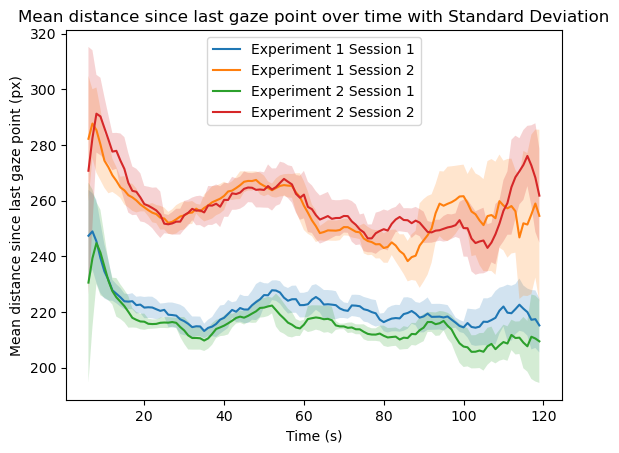

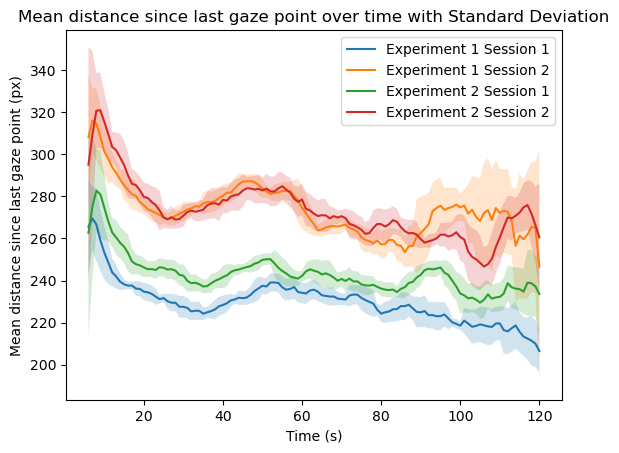

In [38]:
plot_mean_travelled_distance_over_time(data)
plot_mean_travelled_distance_over_time(interpolated_data)

# TODO

In [10]:
def with_time_since_last_column(data: pd.DataFrame) -> pd.DataFrame:
    """
    Add a column with the time since the previous gaze point in seconds.

    Args:
        data (pd.DataFrame): The eye tracking data.

    Returns:
        pd.DataFrame: The eye tracking data with the time since last gaze point column.
    """
    data = data.groupby(["ExperimentId", "SessionId", "ParticipantId", "SequenceId"])
    groups = [data.get_group(group) for group in data.groups]

    for i, group in enumerate(groups):
        group = group.copy()
        group = group.sort_values("Timestamp")
        time_since_last = group["Timestamp"].diff().fillna(0)
        group["TimeSinceLast"] = time_since_last
        groups[i] = group
    data = pandas.concat(groups)

    return data

In [11]:
frequency_data = data.copy()
frequency_data = with_time_since_last_column(frequency_data)
frequency_data.head()

,ExperimentId,SessionId,ParticipantId,SequenceId,GazeX,GazeY,Timestamp,TimeSinceStart,GazeXPixel,GazeYPixel,DistanceSinceLast,TimeSinceLast
0,0,0,0,6,0.432292,0.097331,638333843770694815,0.000000,2656.0,299.0,0.000000,0.0
1,0,0,0,6,0.495931,0.023763,638333843771182747,0.048793,3047.0,73.0,451.615987,487932.0
2,0,0,0,6,0.503581,0.035807,638333843772268532,0.157372,3094.0,110.0,59.816386,1085785.0
3,0,0,0,6,0.609375,0.466146,638333843773280169,0.258535,3744.0,1432.0,1473.154439,1011637.0
4,0,0,0,6,0.696289,0.862956,638333843774304305,0.360949,4278.0,2651.0,1330.833198,1024136.0


In [118]:
def get_mean_distance_ot(data: pd.DataFrame) -> pd.DataFrame:
    """
    Get the mean distance between the current and the previous gaze point over time.

    Args:
        data (pd.DataFrame): The eye tracking data.

    Returns:
        pd.DataFrame: The mean distance over time.
    """
    mean_distance_data = data.copy()
    mean_distance_data["TimeSinceStart"] = mean_distance_data["TimeSinceStart"].astype(int)
    mean_distance = mean_distance_data.groupby("TimeSinceStart")["DistanceSinceLast"].mean().reset_index()

    return mean_distance


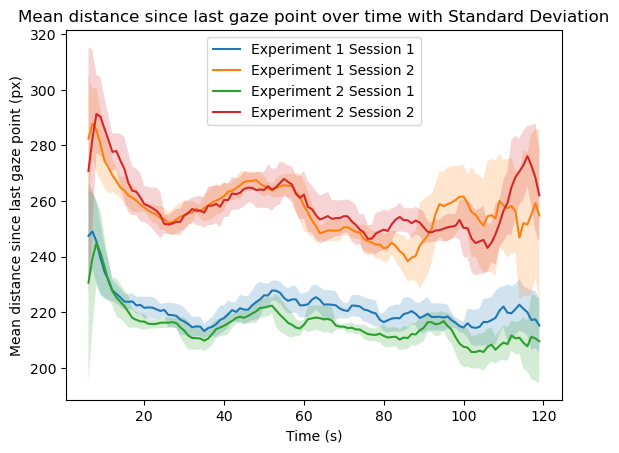

In [119]:
mean_distance_ot_exp1_ses1 = get_mean_distance_ot(exp1_ses1_data)
mean_distance_ot_exp1_ses2 = get_mean_distance_ot(exp1_ses2_data)
mean_distance_ot_exp2_ses1 = get_mean_distance_ot(exp2_ses1_data)
mean_distance_ot_exp2_ses2 = get_mean_distance_ot(exp2_ses2_data)

window_size = 7
mean_distance_ot_exp1_ses1["SmoothedDistance"] = mean_distance_ot_exp1_ses1["DistanceSinceLast"].rolling(window=window_size).mean()
mean_distance_ot_exp1_ses1["StdDevDistance"] = mean_distance_ot_exp1_ses1["DistanceSinceLast"].rolling(window=window_size).std()

mean_distance_ot_exp1_ses2["SmoothedDistance"] = mean_distance_ot_exp1_ses2["DistanceSinceLast"].rolling(window=window_size).mean()
mean_distance_ot_exp1_ses2["StdDevDistance"] = mean_distance_ot_exp1_ses2["DistanceSinceLast"].rolling(window=window_size).std()

mean_distance_ot_exp2_ses1["SmoothedDistance"] = mean_distance_ot_exp2_ses1["DistanceSinceLast"].rolling(window=window_size).mean()
mean_distance_ot_exp2_ses1["StdDevDistance"] = mean_distance_ot_exp2_ses1["DistanceSinceLast"].rolling(window=window_size).std()

mean_distance_ot_exp2_ses2["SmoothedDistance"] = mean_distance_ot_exp2_ses2["DistanceSinceLast"].rolling(window=window_size).mean()
mean_distance_ot_exp2_ses2["StdDevDistance"] = mean_distance_ot_exp2_ses2["DistanceSinceLast"].rolling(window=window_size).std()

# Plotting with standard deviation shading
plt.plot(mean_distance_ot_exp1_ses1["TimeSinceStart"], mean_distance_ot_exp1_ses1["SmoothedDistance"], label="Experiment 1 Session 1")
plt.fill_between(mean_distance_ot_exp1_ses1["TimeSinceStart"],
                 mean_distance_ot_exp1_ses1["SmoothedDistance"] - mean_distance_ot_exp1_ses1["StdDevDistance"],
                 mean_distance_ot_exp1_ses1["SmoothedDistance"] + mean_distance_ot_exp1_ses1["StdDevDistance"],
                 alpha=0.2, label="_nolegend_")

plt.plot(mean_distance_ot_exp1_ses2["TimeSinceStart"], mean_distance_ot_exp1_ses2["SmoothedDistance"], label="Experiment 1 Session 2")
plt.fill_between(mean_distance_ot_exp1_ses2["TimeSinceStart"],
                 mean_distance_ot_exp1_ses2["SmoothedDistance"] - mean_distance_ot_exp1_ses2["StdDevDistance"],
                 mean_distance_ot_exp1_ses2["SmoothedDistance"] + mean_distance_ot_exp1_ses2["StdDevDistance"],
                 alpha=0.2, label="_nolegend_")

plt.plot(mean_distance_ot_exp2_ses1["TimeSinceStart"], mean_distance_ot_exp2_ses1["SmoothedDistance"], label="Experiment 2 Session 1")
plt.fill_between(mean_distance_ot_exp2_ses1["TimeSinceStart"],
                 mean_distance_ot_exp2_ses1["SmoothedDistance"] - mean_distance_ot_exp2_ses1["StdDevDistance"],
                 mean_distance_ot_exp2_ses1["SmoothedDistance"] + mean_distance_ot_exp2_ses1["StdDevDistance"],
                 alpha=0.2, label="_nolegend_")

plt.plot(mean_distance_ot_exp2_ses2["TimeSinceStart"], mean_distance_ot_exp2_ses2["SmoothedDistance"], label="Experiment 2 Session 2")
plt.fill_between(mean_distance_ot_exp2_ses2["TimeSinceStart"],
                 mean_distance_ot_exp2_ses2["SmoothedDistance"] - mean_distance_ot_exp2_ses2["StdDevDistance"],
                 mean_distance_ot_exp2_ses2["SmoothedDistance"] + mean_distance_ot_exp2_ses2["StdDevDistance"],
                 alpha=0.2, label="_nolegend_")

# Labels and title
plt.xlabel("Time (s)")
plt.ylabel("Mean distance since last gaze point (px)")
plt.title("Mean distance since last gaze point over time with Standard Deviation")
plt.legend()
plt.show()

In [120]:
def get_mean_distance_pp(data: pd.DataFrame) -> pd.DataFrame:
    """
    Get the mean distance between the current and the previous gaze point over participants.

    Args:
        data (pd.DataFrame): The eye tracking data.

    Returns:
        pd.DataFrame: The mean distance over participants.
    """
    mean_distance_data = data.copy()
    mean_distance = mean_distance_data.groupby(["ExperimentId", "SessionId", "ParticipantId"])["DistanceSinceLast"].mean().reset_index()

    return mean_distance

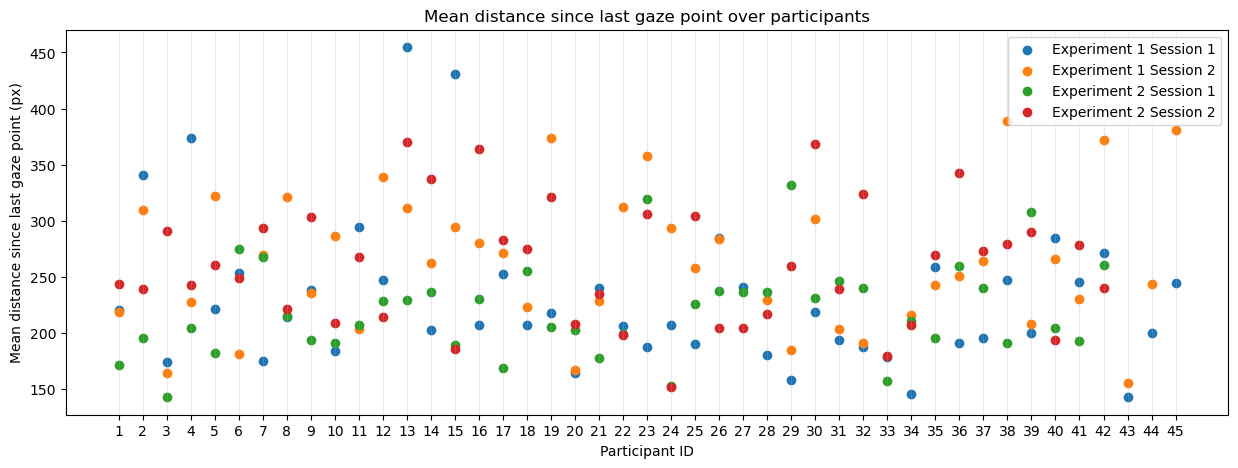

In [121]:
mean_distance_pp_exp1_ses1 = get_mean_distance_pp(exp1_ses1_data)
mean_distance_pp_exp1_ses2 = get_mean_distance_pp(exp1_ses2_data)
mean_distance_pp_exp2_ses1 = get_mean_distance_pp(exp2_ses1_data)
mean_distance_pp_exp2_ses2 = get_mean_distance_pp(exp2_ses2_data)

plt.figure(figsize=(15, 5))
plt.scatter(mean_distance_pp_exp1_ses1["ParticipantId"], mean_distance_pp_exp1_ses1["DistanceSinceLast"], label="Experiment 1 Session 1")
plt.scatter(mean_distance_pp_exp1_ses2["ParticipantId"], mean_distance_pp_exp1_ses2["DistanceSinceLast"], label="Experiment 1 Session 2")
plt.scatter(mean_distance_pp_exp2_ses1["ParticipantId"], mean_distance_pp_exp2_ses1["DistanceSinceLast"], label="Experiment 2 Session 1")
plt.scatter(mean_distance_pp_exp2_ses2["ParticipantId"], mean_distance_pp_exp2_ses2["DistanceSinceLast"], label="Experiment 2 Session 2")
plt.xticks(mean_distance_pp_exp1_ses1["ParticipantId"])
plt.xlabel("Participant ID")
plt.ylabel("Mean distance since last gaze point (px)")
plt.title("Mean distance since last gaze point over participants")
plt.legend()
plt.grid(axis='x', alpha=0.25)
plt.show()